**So let's go!**

There are basically three types of recommender systems:-

> *  **Demographic Filtering**- They provide each user with generic recommendations based on the popularity and/or genre of movies. Users that share similar demographic characteristics are recommended the same movies by the system. Since every user is unique, this method is seen excessively simplistic. This system's main tenet is that films with greater popularity and critical acclaim are more likely to be enjoyed by general audiences.




> *  **Content Based Filtering**- On the basis of a specific item, they recommend related things. To generate these suggestions, our system makes use of item metadata about movies, including genre, director, description, actors, etc. These recommender systems work on the general principle that if a user enjoyed a specific item, they will likely enjoy something similar.


> *  **Collaborative Filtering**- This algorithm finds people who share interests in common and makes suggestions based on that finding. Unlike their content-based equivalents, collaborative filters do not require item metadata.


Let's load the data now.

In [56]:
import pandas as pd 
import numpy as np 

credits_data=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
movies_data=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
credits_data.columns = ['id','tittle','cast','crew']
movies_data= movies_data.merge(df1,on='id')




In [57]:
movies_data.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# **Demographic Filtering** -
 
So, I'll be using IMDB's weighted rating (wr) as a score metric for our movies which is given as :

![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the movie's total number of votes;
* m is the minimum number of votes needed to be in the chart; 
* R is the movie's average rating; 
* C is the mean vote for the entire report.

Since v(**vote_count**), R (**vote_average**), and C are already known, C may be computed as 


In [61]:
C= movies_data['vote_average'].mean()
C

6.092171559442011

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [62]:
m= movies_data['vote_count'].quantile(0.9)
m

1838.4000000000015

Now, we can filter out the movies that qualify for the chart 

In [63]:
filtered_movies = movies_data.copy()
filtered_movies = filtered_movies[filtered_movies['vote_count'] >= m]
print(filtered_movies.shape)

(481, 23)


It is evident that 481 films meet the requirements to be included in this list. We now have to figure out our metric for every eligible film. In order to accomplish this, we'll define a new feature **score** and a function called **weighted_rating()**. We'll use this function to apply to our DataFrame of qualified movies in order to determine the value of this feature:

In [64]:
def calculate_rating(data, minimum_votes=m, average_vote=C):
    vote_count = data['vote_count']
    vote_average = data['vote_average']
    # Calculation based on the IMDB formula
    return (vote_count/(vote_count+minimum_votes) * vote_average) + (minimum_votes/(minimum_votes+vote_count) * average_vote)


In [65]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
filtered_movies['score'] = filtered_movies.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [67]:
#Sort movies based on score calculated above
filtered_movies = filtered_movies.sort_values('score', ascending=False)

#Print the top 15 movies
filtered_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


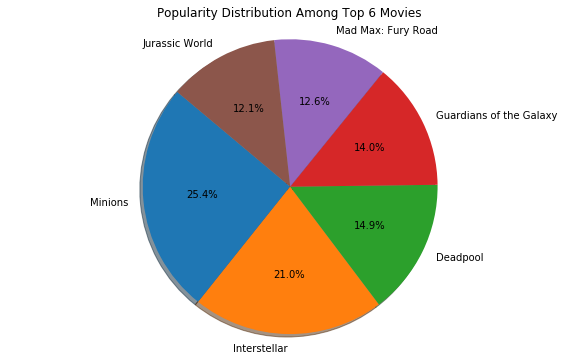

In [68]:
import matplotlib.pyplot as plt

# Sort the dataframe by popularity
sorted_movies = movies_data.sort_values('popularity', ascending=False)

# Select the top 6 popular movies
top_movies = sorted_movies.head(6)

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(top_movies['popularity'], labels=top_movies['title'], autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Popularity Distribution Among Top 6 Movies")
plt.show()



It's important to remember that these demographic recommenders give each user access to a general chart of suggested movies. They don't take into account the preferences and interests of a specific user.
At this point, we switch to Content-Based Filtering, a more sophisticated technique. 

# **Content Based Filtering**
In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.


## **Plot description based Recommender**

Based on the plot descriptions of each movie, we will calculate pairwise similarity ratings for each one and then suggest movies based on those similarity values. The **overview** feature of our dataset provides a description of the plot. 
Let's examine the information. 

In [15]:
movies_data['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

Anyone among you who has dabbled in text processing understands that each overview's word vector needs to be converted.
We will now calculate the TF-IDF (Term Frequency-Inverse Document Frequency) vectors for every overview.

Term frequency, for those who may be wondering, is the proportionate frequency of a word in a document, represented as **(term instances/total instances)**.
The relative count of documents that contain the word is known as the inverse document frequency, and it is expressed as **log(number of documents/documents with term)**.
Each word's total significance to the papers in which it appears is equal to **TF * IDF**.

This will provide you with a matrix where, like before, each row represents a movie and each column represents a word from the overview vocabulary (all the words that appear in at least one document). By doing this, the relevance of terms that frequently appear in plot overviews is diminished, and as a result, their impact in determining the final similarity score is decreased.

Thankfully, a built-in TfIdfVectorizer class in scikit-learn allows you to generate the TF-IDF matrix in a few lines. Isn't that fantastic? 

In [69]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
movies_data['overview'] = movies_data['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies_data['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

In [70]:
# Import sigmoid_kernel
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel similarity matrix
sigmoid_sim = sigmoid_kernel(tfidf_matrix, tfidf_matrix)


We will create a function that, given a movie title as input, returns a list of the ten most comparable films. First, a reverse mapping between movie names and DataFrame indices is required for this. Put differently, we require a way to determine, from the title, the index of a movie in our metadata DataFrame.

In [71]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movies_data.index, index=df2['title']).drop_duplicates()


We are now in a good position to define our recommendation function. These are the following steps we'll follow :
* Get the index of the movie given its title.
* Get the list of sigmoid similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [23]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [74]:
def find_similar_movies(film_title, similarity_matrix=sigmoid_sim):
    # Get the index of the movie that matches the film_title
    film_index = indices[film_title]

    # Get the pairwise similarity scores of all movies with that movie
    similarity_scores = list(enumerate(similarity_matrix[film_index]))

    # Sort the movies based on the similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    top_scores = similarity_scores[1:11]

    # Get the movie indices
    top_movie_indices = [i[0] for i in top_scores]

    # Return the top 10 most similar movies
    return movies_data['title'].iloc[top_movie_indices]


In [76]:
find_similar_movies('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [77]:
find_similar_movies('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

## **Credits, Genres and Keywords Based Recommender**
It should go without saying that using better metadata would improve the quality of our recommender. In this part, we will precisely accomplish that. Based on the following metadata—the director, the top three actors, similar genres, and the movie narrative keywords—we will construct a recommender system.

We must extract the three most significant actors, the director, and the movie's keywords from the cast, crew, and keywords aspects. Our data is now available as "stringified" lists; we must transform it into a structure that is both safe and practical.

In [78]:
import json

# Define the features
features = ['cast', 'crew', 'keywords', 'genres']

# Parse the stringified features into their corresponding python objects
for feature in features:
    movies_data[feature] = movies_data[feature].apply(json.loads)


Next, we'll write functions that will help us to extract the required information from each feature.

In [80]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def fetch_director(crew_data):
    for member in crew_data:
        if member['job'] == 'Director':
            return member['name']
    return np.nan


In [79]:
# Returns the list top 3 elements or entire list; whichever is more.
def extract_top_elements(element_list):
    if isinstance(element_list, list):
        element_names = [element['name'] for element in element_list]
        # Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(element_names) > 3:
            element_names = element_names[:3]
        return element_names

    # Return empty list in case of missing/malformed data
    return []


In [81]:
# Define new director, cast, genres and keywords features that are in a suitable form.
movies_data['director'] = movies_data['crew'].apply(fetch_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies_data[feature] = movies_data[feature].apply(extract_top_elements)

In [83]:
# Print the new features of the first 3 films
movies_data[['title', 'cast', 'director', 'keywords', 'genres']].head(5)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan,"[dc comics, crime fighter, terrorist]","[Action, Crime, Drama]"
4,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton,"[based on novel, mars, medallion]","[Action, Adventure, Science Fiction]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [84]:
def clean_data(x):
    if isinstance(x, list):
        return list(map(lambda i: str.lower(i.replace(" ", "")), x))
    else:
        return str.lower(x.replace(" ", "")) if isinstance(x, str) else ''


In [85]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies_data[feature] = movies_data[feature].apply(clean_data)

We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [86]:
def combine_features(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies_data['comb_features'] = movies_data.apply(combine_features, axis=1)


The next steps are the same as those we took with our recommender based on a storyline description. The fact that we employ **CountVectorizer()** rather than TF-IDF is one significant distinction. This is due to the fact that we do not want to minimize the contribution of an actor or director who has made comparatively more films. There's not much intuitive sense about it.

In [88]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies_data['comb_features'])

In [91]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the Sigmoid Kernel Similarity matrix based on the count_matrix
sigmoid_sim2 = sigmoid_kernel(count_matrix, count_matrix)


In [90]:
# Reset index of our main DataFrame and construct reverse mapping as before
movies_data = movies_data.reset_index()
indices = pd.Series(movies_data.index, index=df2['title'])

We can now reuse our **find_similar_movies()** function by passing in the new **sigmoid_sim2** matrix as your second argument.

In [92]:
find_similar_movies('The Dark Knight Rises', sigmoid_sim2)

65                     The Dark Knight
119                      Batman Begins
1196                      The Prestige
3073                 Romeo Is Bleeding
72                       Suicide Squad
82      Dawn of the Planet of the Apes
157             Exodus: Gods and Kings
210                     Batman & Robin
280                     Public Enemies
299                     Batman Forever
Name: title, dtype: object

In [93]:
find_similar_movies('The Godfather', sigmoid_sim2)

867     The Godfather: Part III
2731     The Godfather: Part II
1018            The Cotton Club
1170    The Talented Mr. Ripley
1209              The Rainmaker
1394              Donnie Brasco
1525             Apocalypse Now
1850                   Scarface
2280                Sea of Love
2649          The Son of No One
Name: title, dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. 

**Collaborative in Filtering**

Our content-based engine has some very serious drawbacks. It can only recommend films that are similar to a specific film. In other words, it lacks the ability to identify preferences and provide recommendations across genres.

Furthermore, our engine isn't very personalized because it doesn't take into account the individual preferences and prejudices of a user. Regardless of identity, anyone using our system to get recommendations based on a movie will get the same results for that movie.

Consequently, in order to provide movie watchers with recommendations, we shall employ a method known as collaborative filtering in this section.
Essentially, there are two types:

* **User-based filtering** – These systems suggest items to a user based on what other users have found appealing. We have two options for comparing two users' similarities: cosine similarity or pearson correlation.


* **Collaborative Filtering Based on Items** - The item-based CF suggests items based on their similarity with the items that the target user assessed, as opposed to calculating the similarity between users. Similarly, Pearson Correlation or Cosine Similarity can be used to calculate the similarity. The primary distinction lies in the fact that item-based collaborative filtering fills in the gaps vertically, while user-based CF does so horizontally. For the film Me Before You, the corresponding table demonstrates how to proceed.




In [10]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
import pandas as pd

# Load the data
rating_reader = Reader()
movie_ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')

# Load the data into Surprise dataset structure
data = Dataset.load_from_df(movie_ratings[['userId', 'movieId', 'rating']], rating_reader)

# Use the SVD algorithm
svd = SVD()

# Perform k-fold cross-validation
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9014  0.8970  0.8933  0.8972  0.8952  0.8968  0.0027  
MAE (testset)     0.6933  0.6899  0.6862  0.6913  0.6906  0.6903  0.0023  
Fit time          6.29    6.20    6.37    6.19    6.27    6.27    0.07    
Test time         0.19    0.28    0.18    0.28    0.18    0.22    0.05    


{'test_rmse': array([0.90138046, 0.89702839, 0.89329024, 0.89719161, 0.89516401]),
 'test_mae': array([0.69333122, 0.68987291, 0.6861767 , 0.69128299, 0.69061074]),
 'fit_time': (6.294324159622192,
  6.201390981674194,
  6.374143362045288,
  6.185317516326904,
  6.274022102355957),
 'test_time': (0.1877272129058838,
  0.2810978889465332,
  0.18181490898132324,
  0.27690958976745605,
  0.18236684799194336)}

In [11]:
movie_ratings[movie_ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [13]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.8990360472116743, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of **2.899**. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## **Conclusion** 
We create recommenders using demographic , content- based and collaborative filtering. While demographic filtering is very elemantary and cannot be used practically, **Hybrid Systems** can take advantage of content-based and collaborative filtering as the two approaches are proved to be almost complimentary.
This model was very baseline and only provides a fundamental framework to start with.